In [16]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
import pandas as pd

In [17]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /Users/arecalde/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


In [18]:
import pandas as pd
import os

# Find the CSV file in the downloaded path
data_dir = path
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
print("CSV files found:", csv_files)

# Load the main dataset (usually 'WA_Fn-UseC_-Telco-Customer-Churn.csv')
df = pd.read_csv(os.path.join(data_dir, csv_files[0]))
print("DataFrame shape:", df.shape)
df.head()

CSV files found: ['WA_Fn-UseC_-Telco-Customer-Churn.csv']
DataFrame shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [19]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [20]:
# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

categorical_columns = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    if col != 'customerID':  # Exclude 'customerID'
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

print("Categorical columns encoded:", categorical_columns)

Categorical columns encoded: Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges',
       'Churn'],
      dtype='object')


In [21]:
df.dtypes

customerID           object
gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges          int64
Churn                 int64
dtype: object

In [22]:
# Check for imbalance in the target variable
print("Target variable distribution:")
print(df['Churn'].value_counts())

Target variable distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64


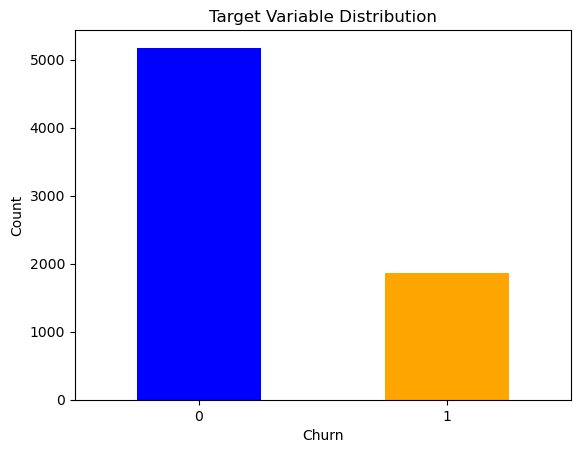

In [23]:
import matplotlib.pyplot as plt

# Plot the imbalance
df['Churn'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Target Variable Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [24]:
# Example: Create tenure groups
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 60, 72], labels=['0-12', '13-24', '25-48', '49-60', '61-72'])

In [25]:
# Convert 'tenure_group' from category to integer codes for XGBoost compatibility
if 'tenure_group' in df.columns:
    df['tenure_group'] = df['tenure_group'].cat.codes

In [26]:
# Example: Count number of services
service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df['num_services'] = df[service_cols].apply(lambda x: sum(x == 1), axis=1)

In [27]:
# Example: Average monthly charges
df['avg_monthly_charge'] = df['TotalCharges'] / (df['tenure'].replace(0, 1))

In [28]:
# Create an interaction feature between Contract and PaymentMethod
df['Contract_Payment'] = df['Contract'].astype(str) + "_" + df['PaymentMethod'].astype(str)
# Encode the new interaction feature
le_interaction = LabelEncoder()
df['Contract_Payment'] = le_interaction.fit_transform(df['Contract_Payment'])

print("Interaction feature 'Contract_Payment' created and encoded.")

Interaction feature 'Contract_Payment' created and encoded.


In [29]:
from sklearn.model_selection import train_test_split

# Calculate scale_pos_weight for XGBoost
scale_pos_weight = len(df[df['Churn'] == 0]) / len(df[df['Churn'] == 1])
print("scale_pos_weight:", scale_pos_weight)

# Define features and target
X = df.drop(columns=['Churn', 'customerID'])
y = df['Churn']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

scale_pos_weight: 2.7683253076511503
Training set size: (5634, 23)
Testing set size: (1409, 23)


In [30]:
from xgboost import XGBClassifier

# Train XGBoost model
xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train, y_train)

# Predict on test set
y_pred = xgb.predict(X_test)

# Evaluate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7721788502484032

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.81      0.84      1036
           1       0.56      0.68      0.61       373

    accuracy                           0.77      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.79      0.77      0.78      1409


Confusion Matrix:
 [[834 202]
 [119 254]]


/Users/arecalde/anaconda3/envs/ds_course_lessons/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:36:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


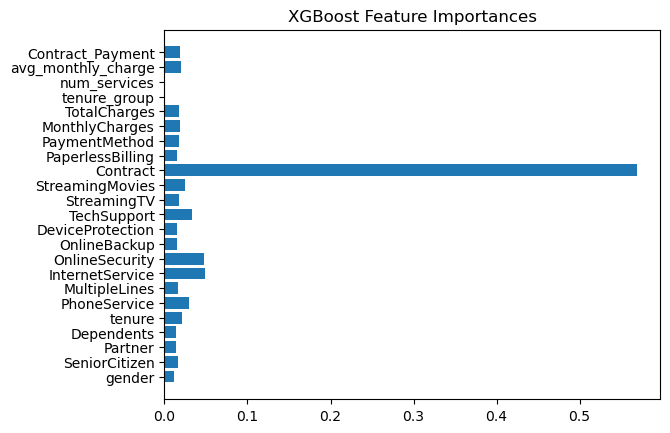

In [31]:
import matplotlib.pyplot as plt
xgb.feature_importances_
plt.barh(X.columns, xgb.feature_importances_)
plt.title("XGBoost Feature Importances")
plt.show()

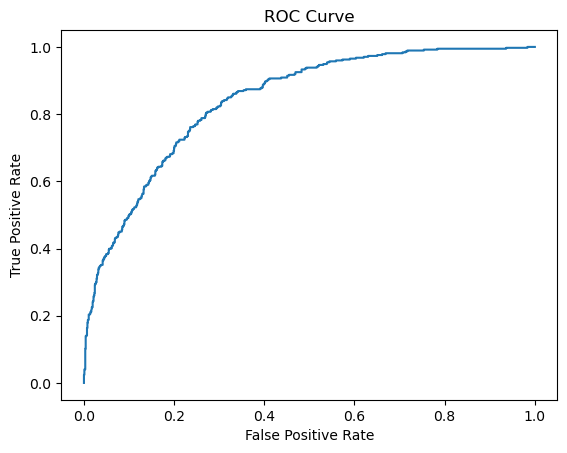

ROC AUC: 0.8412162162162161


In [32]:
from sklearn.metrics import roc_auc_score, roc_curve

y_proba = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("ROC AUC:", roc_auc_score(y_test, y_proba))

In [39]:
import os
os.environ['PYTHONWARNINGS'] = 'ignore'

from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Expanded parameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 10, 12],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.01, 0.05, 0.1, 0.2, 0.5, 1],
    'reg_lambda': [0.5, 1, 1.5, 2, 3, 5, 10],
    'reg_alpha': [0, 0.01, 0.1, 0.5, 1, 2, 5],
    'scale_pos_weight': [scale_pos_weight]
}

xgb_clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Randomized search with more iterations
random_search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=50,  # Increase for a more exhaustive search
    scoring='f1',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.3, max_depth=8, n_estimators=300, reg_alpha=5, reg_lambda=10, scale_pos_weight=2.7683253076511503, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.3, max_depth=8, n_estimators=300, reg_alpha=5, reg_lambda=10, scale_pos_weight=2.7683253076511503, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, n_estimators=200, reg_alpha=0, reg_lambda=0.5, scale_pos_weight=2.7683253076511503, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, n_estimators=200, reg_alpha=0, reg_lambda=0.5, scale_pos_weight=2.7683253076511503, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, n_estimators=200, reg_alpha=0, reg_lambda=0.5, scale_pos_weight=2.7683253076511503, subsample=0.8;

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                                             0.9, 1.0],
                                        'gamma': [0, 0.01, 0.05, 0.1, 0.2, 0.5,
                                                  1],
                                        'learning_rate': [0.001, 0.005, 0.01,
                                                          0.05, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 10, 12],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_alpha': [0, 0.01, 0.1, 0.5, 1, 2,
                                                      5],
                                        'reg_lambda': [0.5, 1, 1.5, 2, 3, 5,
                                                       10],
                                        'scale_pos_weight': [2.7683253076511503],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]},
                   random_state=42, scoring='f1', verbose=2)

In [40]:
print("Best parameters found:", random_search.best_params_)
print("Best F1 score:", random_search.best_score_)

Best parameters found: {'subsample': 0.5, 'scale_pos_weight': 2.7683253076511503, 'reg_lambda': 10, 'reg_alpha': 0.01, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 0.8}
Best F1 score: 0.6315059493226759


In [41]:
# Evaluate the best XGBoost model from RandomizedSearchCV
best_xgb = random_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Best XGBoost Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nBest XGBoost Classification Report:\n", classification_report(y_test, y_pred_best))
print("\nBest XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

Best XGBoost Accuracy: 0.7735982966643009

Best XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.76      0.83      1036
           1       0.55      0.82      0.66       373

    accuracy                           0.77      1409
   macro avg       0.73      0.79      0.74      1409
weighted avg       0.82      0.77      0.78      1409


Best XGBoost Confusion Matrix:
 [[786 250]
 [ 69 304]]
